In [1]:
from __future__ import annotations

import importlib
import pathlib

import plotly.express as px
import plotly.graph_objects as go
import polars
import theme
from plotly.subplots import make_subplots
from proxystore.utils.data import bytes_to_readable

importlib.reload(theme)

<module 'theme' from '/home/jgpaul/workspace/sc24-proxystore-analysis/notebooks/theme.py'>

In [2]:
def load_data(directory):
    run_data = polars.concat(
        polars.read_csv(f)
        for f in pathlib.Path(directory).glob('**/results.csv')
    )
    return run_data

In [5]:
def generate_figure(data, layout=None):
    data = data.with_columns(
        (
            polars.col('end_tasks_done_timestamp')
            - polars.col('start_submit_tasks_timestamp')
        ).alias('runtime'),
    ).sort('workers')
    data = data.with_columns(
        (polars.col('task_count') / polars.col('runtime')).alias(
            'tasks_per_second',
        ),
    )

    data_sizes = (
        data.select(polars.col('data_size_bytes')).to_series().to_list()
    )
    data_sizes = sorted(set(data_sizes))
    data_sizes_readable = [bytes_to_readable(size) for size in data_sizes]

    workers = data.select(polars.col('workers')).to_series().to_list()
    workers = sorted(set(workers))

    titles = [f'Stream Item Size: {size}' for size in data_sizes_readable]
    fig = make_subplots(
        rows=1,
        cols=len(data_sizes),
        horizontal_spacing=0.025,
        subplot_titles=titles,
        shared_yaxes=True,
    )

    colors = px.colors.qualitative.Bold[0:2]
    markers = ('circle', 'diamond')

    for i, data_size in enumerate(data_sizes):
        coldata = data.filter(polars.col('data_size_bytes') == data_size)
        for j, use_proxies in enumerate((False, True)):
            subdata = coldata.filter(polars.col('use_proxies') == use_proxies)
            scatter_data = go.Scatter(
                x=subdata['workers'],
                y=subdata['tasks_per_second'],
                name='ProxyStream' if use_proxies else 'Default',
                line=dict(color=colors[j]),
                mode='lines+markers',
                marker=dict(symbol=markers[j], size=10),
                showlegend=i == 0,
            )
            fig.add_trace(scatter_data, row=1, col=i + 1)
            fig.update_xaxes(title_text='Workers', row=1, col=i + 1)

        baseline_workers = min(workers) - 1
        task_sleep = coldata.row(0, named=True)['task_sleep']
        baseline_task_per_second = baseline_workers / task_sleep
        ideal_task_per_second = [
            baseline_task_per_second * (w - 1) for w in workers
        ]

        scatter_ideal = go.Scatter(
            x=workers,
            y=ideal_task_per_second,
            name='Ideal',
            line=dict(color='black', dash='dash'),
            mode='lines',
            showlegend=i == 0,
        )
        fig.add_trace(scatter_ideal, row=1, col=i + 1)

    fig.update_annotations(font_size=12)
    xaxis = {
        'xaxis' if i == 0 else f'xaxis{i+1}': dict(
            type='log',
            tickvals=workers,
        )
        for i in range(len(data_sizes))
    }
    yaxis = {
        'yaxis' if i == 0 else f'yaxis{i+1}': dict(
            type='log', dtick=0.30102999566,
        )
        for i in range(len(data_sizes))
    }
    fig.update_layout({**xaxis, **yaxis})

    layout = {} if layout is None else layout
    fig.update_layout(
        # title={'text': 'Task Pipelining with Futures'},
        yaxis_title='Tasks / Second',
        legend=dict(yanchor='top', y=0.98, xanchor='left', x=0.005),
        template='proxystore',
        **layout,
    )

    return fig

## Alderaan Testing Run

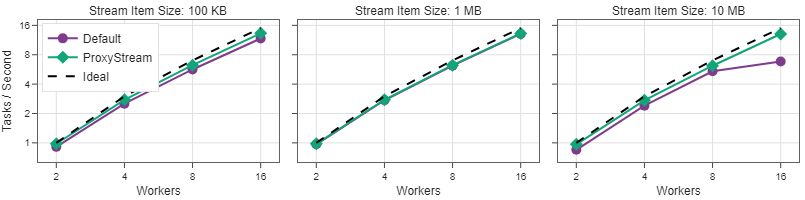

In [6]:
data = load_data('../data/alderaan/1-stream-scaling/')

layout = dict(width=1000, height=200, margin=dict(t=20))

fig = generate_figure(data, layout)
fig.show()

figure_dir = pathlib.Path('../figures/alderaan/')
figure_dir.mkdir(exist_ok=True)
fig.write_image(figure_dir / '1-stream-scaling.pdf')